# Multiple Methods for Spam Classification
---
Rita Rezende Borges de Lima <br>
DCC - UFMG

# Main Goals
In this assignment the objective is to **classify spam emails** through **various algorithms** such as *Naive Bayes Classification*, *Support Vector Machines*, *Random Forrest Classifier*, *Gradient Boost* and a *Recurrent Neural Network* so to **compare** using cross-validation the **accuracy of the models** on the given task. My hypotheses are that the best results will be obtained through the Neural Net. 

## Libraries

Several python modules we're needed. The module *Pandas* was used for handling the data frames, *re* and multiple *NLTK* modules we're used for data preprocessing, *Matplotlib* was used to improve report visualization, *Scikit-learn* was used to extract features and for its classifiers and *TensorFlow* and *Keras* were used for building the Neural Network.

In [1]:
import nltk, re, json, os

import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
from gensim.parsing.preprocessing import remove_stopwords
from string import punctuation
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag
from nltk.tokenize import word_tokenize

from data.input_data.contractions import contractionsdict
contractions_re=re.compile('(%s)' % '|'.join(contractionsdict.keys()))

from data.input_data.hyperparams import random_forest_hp, svm_hp, grad_boosting_hp


nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
snowball = SnowballStemmer(language='english')
wnl = WordNetLemmatizer()

from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.svm import SVC

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional
from keras.models import Model, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report, precision_score, recall_score

from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ritar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ritar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Data Preprocessing

For this assignment, I used the [Spam Mails Dataset](https://www.kaggle.com/venky73/spam-mails-dataset) found on kaggle, which was retrieved from [Enron Spam](http://www2.aueb.gr/users/ion/data/enron-spam/). **The data frame consists of** three columns, **a textual label** (ham or spam), **the text on the email** and a **boolean label** (0 or 1) . To achieve better results, **the textual data**, which consists of several e-mails that were either considered legit or spam, **was filtered through various process** such as lowercasing, expanding contractions, stopword, punctuation and noise removal and stemming. 

### The used dataframe:
In order to be able to compare the processed data with the original one we'll make a copy!

In [2]:
df = pd.read_csv("./data/input_data/spam_ham.csv")
cleaned_df = df.copy()
cleaned_df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


### An exemple of a legit email and an exemple of spam:

In [3]:
ham = df[df['label_num'] == 0]
display(HTML("<b>Legit Email:</b>"))
display(HTML(ham.iloc[0]['text']))

display(HTML("<b>Spam:</b>"))
spam = df[df['label_num'] == 1]
display(HTML(spam.iloc[1]['text']))

### Lowercasing

All text will be lower case, so our models won't differ in identical words with different spelling.

In [4]:
example_number = 4

cleaned_df['text'] = cleaned_df['text'].apply(lambda x:x.lower())
cleaned_df['text'][example_number]

"subject: re : indian springs\r\nthis deal is to book the teco pvr revenue . it is my understanding that teco\r\njust sends us a check , i haven ' t received an answer as to whether there is a\r\npredermined price associated with this deal or if teco just lets us know what\r\nwe are giving . i can continue to chase this deal down if you need ."

### Expanding contractions
To have a cleaner text we'll transform contractions (which are quite common in legit emails and spam) in full words. <br>
*Example:* we'll -> we will

In [5]:
def expand_contractions(text,contractionsdict=contractionsdict):
    def replace(match):
        return contractionsdict[match.group(0)]
    return contractions_re.sub(replace, text)

cleaned_df['text'] = cleaned_df['text'].apply(lambda x:expand_contractions(x))
cleaned_df['text'][example_number]

'subject: re : indian springs\r\nthis deal is to book the teco pvr revenue . it is my understanding that teco\r\njust sends us a check , i have not received an answer as to whether there is a\r\npredermined price associated with this deal or if teco just lets us know what\r\nwe are giving . i can continue to chase this deal down if you need .'

### Removing Noise,  Punctuation and Stopwords
Numbers, non-ascii characters and HTML markups are also removed.

In [6]:
def text_cleaning(email):
    email=re.sub("(<.*?>)","",email)             # remove html markup
    email=re.sub("(\r\n)|(\r)|(\n)"," ",email)
    email=re.sub("[^A-Za-z ]","",email)          #remove non-ascii and digits
    email=re.sub(' +', ' ', email)               #remove extra whitespaces
    return email

cleaned_df['text'] = cleaned_df['text'].apply(lambda x:text_cleaning(x))
cleaned_df['text'] = cleaned_df['text'].apply(lambda x:x.translate(str.maketrans('', '', punctuation)))
cleaned_df['text'] = cleaned_df['text'].apply(lambda x:remove_stopwords(x))

cleaned_df['text'][example_number]

'subject indian springs deal book teco pvr revenue understanding teco sends check received answer predermined price associated deal teco lets know giving continue chase deal need'

### Stemming
To improve results we can group together the inflected forms of a word so they can be analysed as a single item, identified by its root.

In [7]:
def stem_texts(email):  
    return (" ").join([snowball.stem(word) for word in word_tokenize(email)])
    
cleaned_df['text'] = cleaned_df['text'].apply(lambda x:stem_texts(x))
cleaned_df['text'][example_number]

'subject indian spring deal book teco pvr revenu understand teco send check receiv answer predermin price associ deal teco let know give continu chase deal need'

### Saving the preprocessed dataframe
The data will be saved in a file, *preprocessed_spam_ham*, so all our models can use it!

In [8]:
cleaned_df.to_csv("./data/input_data/preprocessed_spam_ham.csv")

# Classifying spam in emails using Naive Bayes Methods

According to the Scikit-Learn documentation, 

> Naive Bayes methods are a set of supervised learning algorithms based on applying Bayes’ theorem with the "naive" assumption of conditional independence between every pair of features given the value of the class variable. 

The Naive Bayes' Theorem finds the probability of an event occurring given the probability of another event that has already occurred.

So given a class variable *Y* and a dependent feature vector *X*<sub>1</sub>... *X*<sub>n</sub>:

![image.png](./images/bayes_theorem.png)

Assuming conditional independence such that:

![image.png](./images/assumption.png)

For all *i* this relationship is simplified to

![image.png](./images/simplification.png)

Since *P(X*<sub>1</sub>,..., *X*<sub>N</sub>*)* is constant for each input, the following classification rule is valid:

![image.png](./images/classification.png)

## Exploratory Data Analysis

As seen below **there are way more legit emails than spam**, to handle with the imbalanced dataset **we're going to resample it** so to use it in the *Multinomial Naive Bayes*, and we're also going to use the *Complement Naive Bayes*, which is particularly suited for imbalanced data sets.

In [9]:
df = pd.read_csv("./data/input_data/preprocessed_spam_ham.csv")

df_spam = df[df['label']=='spam']
df_ham = df[df['label']=='ham']

print('Amount of hams: ', len(df_ham),' Amount of spams: ', len(df_spam))

Amount of hams:  3672  Amount of spams:  1499


## Multinomial Naive Bayes and Resampling data
Through the function *resample* in the **scikit-learn** module, observations in the larger class (hams) will be randomly removed to prevent its signal from dominating the learning algorithm.

In [10]:
df_ham_downsampled = resample(df_ham, replace=False, n_samples=len(df_spam), random_state=42)
resampled_df = pd.concat([df_ham_downsampled, df_spam])

### Train and Test Split 

Through the function *train_test_split* in the **scikit-learn** module, we will split the data frame in proportions 20-80.

In [11]:
x_train_rs, x_test_rs, y_train_rs, y_test_rs = train_test_split(resampled_df['text'], resampled_df['label_num'], test_size = 0.2, random_state = 42)

### Feature Extraction

We are going to use the function *TfidfVectorizer* from the **scikit-learn** module to extract features.

In [12]:
vectorizer_rs = TfidfVectorizer()
features_train_transformed_rs = vectorizer_rs.fit_transform(x_train_rs.tolist()) 
features_test_transformed_rs  = vectorizer_rs.transform(x_test_rs)

actual = y_test_rs.tolist()

### Train our Naive Bayes Model

We'll fit the *Naive Bayes* model, the *MultinomialNB* function, to our *TF-IDF* vector version of x_train, and the true output labels stored in y_train.

In [13]:
classifier = MultinomialNB()
classifier.fit(features_train_transformed_rs, y_train_rs)

labels = classifier.predict(features_test_transformed_rs)

### Measuring Accuracy 

Finally, using our test sets, we'll evaluate the model accuracy using built-in functions from the **scikit** library.

In [14]:
general_scores = pd.DataFrame({'Method': ['Multinomial Naive Bayes'], 'Accuracy': [accuracy_score(actual, labels)], 
                'F-measure': [f1_score(actual, labels, average = 'binary')], 'Recall': [recall_score(actual, labels)],
                'Precision': [precision_score(actual, labels)] }) 


general_scores.to_csv("./data/scores/general.csv", index=False)

display(HTML(f'<b>Accuracy: </b> {accuracy_score(actual, labels)}'))
display(HTML(f'<b>F-measure: </b> {f1_score(actual, labels, average = "binary")}'))   
display(HTML(f'<b>Recall: </b> {recall_score(actual, labels)}'))
display(HTML(f'<b>Precision: </b> {precision_score(actual, labels)}'))

## Complement Naive Bayes

### Train and Test Split 

Through the function *train_test_split* in the **scikit-learn** module, we will split the data frame in proportions 20-80.

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['label_num'], test_size = 0.2, random_state = 42)

### Feature Extraction

We are going to use the function *TfidfVectorizer* from the **scikit-learn** module to extract features.

In [16]:
vectorizer = TfidfVectorizer()
features_train_transformed = vectorizer.fit_transform(x_train.tolist()) #gives tf idf vector for x_train
features_test_transformed  = vectorizer.transform(x_test) #gives tf idf vector for x_test

actual = y_test.tolist()

### Train our Naive Bayes Model

We'll fit the **scikit-learning** *Naive Bayes* model, the *ComplementNB* function, to our *TF-IDF* vector version of x_train, and the true output labels stored in y_train.

In [17]:
classifier = ComplementNB()
classifier.fit(features_train_transformed, y_train)
labels = classifier.predict(features_test_transformed)

### Measuring Accuracy 

Finally, using our test sets we'll evalue the model accuracy using built-in functions from the **scikit** library.

In [18]:
general_scores = pd.read_csv("./data/scores/general.csv")

ap = pd.DataFrame({'Method': ['Complement Naive Bayes'], 'Accuracy': [accuracy_score(actual, labels)], 
                'F-measure': [f1_score(actual, labels, average = 'binary')], 'Recall': [recall_score(actual, labels)],
                'Precision': [precision_score(actual, labels)] }) 


general_scores = general_scores.append(ap, ignore_index = True)
general_scores.to_csv("./data/scores/general.csv", index=False)

display(HTML(f'<b>Accuracy: </b> {accuracy_score(actual, labels)}'))
display(HTML(f'<b>F-measure: </b> {f1_score(actual, labels, average = "binary")}'))   
display(HTML(f'<b>Recall: </b> {recall_score(actual, labels)}'))
display(HTML(f'<b>Precision: </b> {precision_score(actual, labels)}'))

# Classifying spam in emails using a Random Forest Classifier.

According to the Scikit-Learn documentation, 

> A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

**Decision trees are a component of a random forest algorithm**. The former is **a technique that forms a tree-like structure** that consists of three components: decision nodes, leaf nodes, and a root node. In the algorithm, we **divide the input dataset into branches**, which recursively segregate into other branches **until a leaf node is attained**. The **nodes** in the decision tree **represent attributes that are used for predicting the outcome**.  

The main difference between the decision tree algorithm and the random forest algorithm is that establishing root nodes and segregating nodes is done randomly in the latter. The **random forest employs the bagging method** to generate the required prediction. Bagging **involves using different samples of data** (training data) rather than just one sample. A training dataset comprises observations and features that are used for making predictions. The decision trees produce different outputs, depending on the training data fed to the random forest algorithm. These **outputs will be ranked, and the highest will be selected** as the final output.

### Feature Extraction

We are going to use the function *TfidfVectorizer* from the **scikit-learn** module to extract features. Since we are dealing with the same data frame multiple times, we'll use the same resampling done in the last step.

In [19]:
x_rs, y_rs = resampled_df['text'], resampled_df['label_num']

vectorizer_rs = TfidfVectorizer()
features_transformed_rs = vectorizer_rs.fit_transform(x_rs.tolist()) 
actual = y_rs.tolist()

### Obtaining the Best Set of Hyperparameters

We'll **fit the *RandomForestClassifier* model**,  **to** our ***TF-IDF* vector**, and the true output labels will be stored in y. To obtain better results since the *Random Forest* has multiple hyperparameters, **we will use the *RandomizedSearchCV*** module, we will **also make use of** the built-in **(Stratified)KFold** with 5 folds, so they have a better measure of accuracy. 

In [20]:
def train_model(classifier, hp, filename):

    rsearch = RandomizedSearchCV(estimator = classifier, param_distributions = hp, 
                                 scoring = ['precision', 'recall', 'f1', 'accuracy'], refit = 'f1', cv = 5)
    
    search = rsearch.fit(features_transformed_rs, y_rs)
    classifier.fit(features_transformed_rs, y_rs)

    best_p = search.best_params_
    results = pd.DataFrame.from_dict(search.cv_results_)
    
    with open("./data/calculated_hyperparameters/{}_hp.txt".format(filename), 'w') as convert_file:
        convert_file.write(json.dumps(best_p))
    
    results.to_csv("./data/scores/{}.csv".format(filename))

### Training our Classifier

Checking if we have calculated the best set of hiperparameters and best score, we can check if we havent trained our model yet, and if thats the case we will train it! 

In [21]:
if not os.path.isfile("./data/calculated_hyperparameters/random_forest_hp.txt"):
    
    print("Calculating best set of HP...")
    classifier = RandomForestClassifier()
    train_model(classifier, random_forest_hp, "random_forest")

### Measuring Accuracy 

Finally, using our test sets, we'll evaluate the model accuracy using built-in functions from the **scikit** library.

In [22]:
scores = pd.read_csv("./data/scores/random_forest.csv")
best_acc = scores[scores['rank_test_accuracy'] == 1]

general_scores = pd.read_csv("./data/scores/general.csv")

ap = pd.DataFrame({'Method': 'Random Forrest', 'Accuracy': best_acc["mean_test_accuracy"].values, 
      'F-measure': best_acc["mean_test_f1"].values, 'Recall': best_acc["mean_test_recall"].values,
      'Precision': best_acc["mean_test_precision"].values}) 


general_scores = general_scores.append(ap, ignore_index=True)
general_scores.to_csv("./data/scores/general.csv", index=False)

display(HTML(f'<b>Accuracy: </b> {best_acc["mean_test_accuracy"].values[0]} (+- {best_acc["std_test_accuracy"].values[0]} )'))
display(HTML(f'<b>F-measure: </b> {best_acc["mean_test_f1"].values[0]} (+- {best_acc["std_test_f1"].values[0]} )'))
display(HTML(f'<b>Recall: </b> {best_acc["mean_test_recall"].values[0]} (+- {best_acc["std_test_recall"].values[0]} )'))
display(HTML(f'<b>Precision: </b> {best_acc["mean_test_precision"].values[0]} (+- {best_acc["std_test_precision"].values[0]} )'))

# Classifying spam in emails using a Support Vector Machine

According to the Scikit-Learn documentation, 

> A support vector machine constructs a hyper-plane or set of hyper-planes in a high or infinite dimensional space, which can be used for classification, regression or other tasks. Intuitively, a good separation is achieved by the hyper-plane that has the largest distance to the nearest training data points of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier.

In the Support Vector Machine, the **data will be categorized in points** that may be stated in a finite-dimensional space. Because it may happen that the sets to discriminate are not linearly separable in that space, **the original finite-dimensional space is mapped into a much higher-dimensional space**, presumably **making the separation easier** in that space. To keep the computational cost-efficient, these mappings used in our model ensure that dot products of pairs of input data vectors may be computed easily in terms of the variables in the original space, by defining them in terms of a kernel function that suits the problem. The hyperplanes in the higher-dimensional space are defined as the set of points whose dot product with a vector in that space is constant, where such a set of vectors is an orthogonal (and thus minimal) set of vectors that defines a hyperplane. 

### Feature Extraction

We are going to use the function *TfidfVectorizer* from the **scikit-learn** module to extract features. Since we are dealing with the same data frame multiple times, we'll use the same resampling done in the last step.

In [23]:
x_rs, y_rs = resampled_df['text'], resampled_df['label_num']

vectorizer_rs = TfidfVectorizer()
features_transformed_rs = vectorizer_rs.fit_transform(x_rs.tolist()) 
actual = y_rs.tolist()

### Obtaining the Best Set of Hyperparameters

We'll **fit the *SVC* model,  to our *TF-IDF* vector** version of x_train, and the true output labels stored in y_train. Since we are dealing with the same data frame multiple times, we'll use the same vector of extracted features from the data frame, with resampling done in the last step.

To obtain better results since the *SVC* has multiple hyperparameters, we will **use the *RandomizedSearchCV* module** so to obtain the best set of hyperparameters. We'll **also make use of the built-in (Stratified)KFold** with 5 folds, so they have a better measure of accuracy 

### Training our Classifier

Checking if we have calculated the best set of hyperparameters and best score, we can check if we haven't trained our model yet, and if that's the case we will train it! 

In [24]:
if not os.path.isfile("./data/calculated_hyperparameters/support_vector_hp.txt"):
    
    print("Calculating best set of HP...")
    classifier = SVC()
    train_model(classifier, svm_hp, "support_vector")

### Measuring Accuracy 

Finally, using our test sets, we'll evaluate the model accuracy using built-in functions from the **scikit** library.

In [25]:
scores = pd.read_csv("./data/scores/support_vector.csv")
best_acc = scores[(scores['rank_test_accuracy'] == 1) & (scores['rank_test_f1'] == 1)]
idx = best_acc['rank_test_precision'].idxmax()
best_acc = best_acc.iloc[[idx]]

general_scores = pd.read_csv("./data/scores/general.csv")

ap_svm = pd.DataFrame({'Method': 'Support Vector Machine', 'Accuracy': best_acc["mean_test_accuracy"].values, 
      'F-measure': best_acc["mean_test_f1"].values, 'Recall': best_acc["mean_test_recall"].values,
      'Precision': best_acc["mean_test_precision"].values}) 

general_scores = general_scores.append(ap_svm, ignore_index=True)
general_scores.to_csv("./data/scores/general.csv", index=False)

display(HTML(f'<b>Accuracy: </b> {best_acc["mean_test_accuracy"].values[0]} (+- {best_acc["std_test_accuracy"].values[0]} )'))
display(HTML(f'<b>F-measure: </b> {best_acc["mean_test_f1"].values[0]} (+- {best_acc["std_test_f1"].values[0]} )'))
display(HTML(f'<b>Recall: </b> {best_acc["mean_test_recall"].values[0]} (+- {best_acc["std_test_recall"].values[0]} )'))
display(HTML(f'<b>Precision: </b> {best_acc["mean_test_precision"].values[0]} (+- {best_acc["std_test_precision"].values[0]} )'))

# Classifying spam in emails using a Gradient Boosting

According to the Scikit-Learn documentation,

> Gradient Tree Boosting or Gradient Boosted Decision Trees (GBDT) is a generalization of boosting to arbitrary differentiable loss functions. GBDT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems in a variety of areas including Web search ranking and ecology.

Let's name our output vector *y*, and our input vector *x*. On gradient Boosting we're going to try to find a function *F'(x)* for a function *F(x)* so to minimize a Loss Function, L(y, F(x)):

Algorithm:
1. Well initialize the model with constants

![image.png](./images/constants.png)

2. Well iterate a chosen amount, M, with m being our iteration index:
    
    1. Calculating the residuals:  ![image.png](./images/residuals.png)

    2. We'll adjust the model training with the training set.
    3. We'll calculate the *&gamma;* as the solution of an optimaztion unidimensional problem: 
    
    ![image.png](./images/multipliers.png)
    
    4. We'll update the model: ![image.png](./images/updating.png) 
    
    
References:

https://jerryfriedman.su.domains/ftp/trebst.pdf

### Feature Extraction

We are going to use the function *TfidfVectorizer* from the **scikit-learn** module to extract features. Since we are dealing with the same data frame multiple times, we'll use the same resampling done in the last step.

In [26]:
x_rs, y_rs = resampled_df['text'], resampled_df['label_num']

vectorizer_rs = TfidfVectorizer()
features_transformed_rs = vectorizer_rs.fit_transform(x_rs.tolist()) 
actual = y_rs.tolist()

### Obtaining the Best Set of Hyperparameters

We'll **fit the *GradientBoostingClassifier* model,  to our *TF-IDF* vector** version of x_train, and the true output labels stored in y_train. Since we are dealing with the same data frame multiple times, we'll use the same vector of extracted features from the data frame, with resampling done in the last step.

To obtain better results since the *Gradient Boost* has multiple hyperparameters, we will **use the *RandomizedSearchCV* module so to obtain the best set of hyperparameters**. Well **also make use of** the built-in **(Stratified)KFold** with 5 folds, so they have a better measure of accuracy 

### Training our Classifier

Checking if we have calculated the best set of hyperparameters and best score, we can check if we haven't trained our model yet, and if that's the case we will train it! 

In [27]:
if not os.path.isfile("./data/calculated_hyperparameters/gradient_boosting_hp.txt"):
    
    print("Calculating best set of HP...")
    classifier = GradientBoostingClassifier()
    train_model(classifier, grad_boosting_hp, "gradient_boosting")

### Measuring Accuracy 

Finally, using our test sets, we'll evaluate the model accuracy using built-in functions from the **scikit** library.

In [28]:
general_scores = pd.read_csv("./data/scores/general.csv")
scores = pd.read_csv("./data/scores/gradient_boosting.csv")
best_acc = scores[scores['rank_test_accuracy'] == 1]

ap_svm = pd.DataFrame({'Method': 'Gradient Boosting', 'Accuracy': best_acc["mean_test_accuracy"].values, 
      'F-measure': best_acc["mean_test_f1"].values, 'Recall': best_acc["mean_test_recall"].values,
      'Precision': best_acc["mean_test_precision"].values}) 

general_scores = general_scores.append(ap_svm, ignore_index=True)
general_scores.to_csv("./data/scores/general.csv", index=False)

display(HTML(f'<b>Accuracy: </b> {best_acc["mean_test_accuracy"].values[0]} (+- {best_acc["std_test_accuracy"].values[0]} )'))
display(HTML(f'<b>F-measure: </b> {best_acc["mean_test_f1"].values[0]} (+- {best_acc["std_test_f1"].values[0]} )'))
display(HTML(f'<b>Recall: </b> {best_acc["mean_test_recall"].values[0]} (+- {best_acc["std_test_recall"].values[0]} )'))
display(HTML(f'<b>Precision: </b> {best_acc["mean_test_precision"].values[0]} (+- {best_acc["std_test_precision"].values[0]} )'))

# Classifying spam in emails using a Long Short Term Memory

*Long short-term memory* are a special kind of recurrent neural network that, on the contrary to standard feedforward neural networks, have feedback connections and because of that, are capable of classifying entire sequences of data. LSTM networks were developed to deal with the vanishing gradient problem that can be encountered when training traditional RNNs. 

The first step in an LSTM is to decide what information is thrown away from the cell state, which is made by the sigmoid layer, called "forget gate layer". Next,  we decide what new information is going to be stored in the cell state.  For that, first, a sigmoid layer called the “input gate layer” decides which values will be updated, and then a tanh layer creates a vector of new candidate values, that could be added to the state.  We’ll combine both to create an update to the state. The output will be based on a filtered version of the cell state, this accomplished with a sigmoid layer decides what parts of the cell state it's going to be the output. Then, we put the cell state through a tanh and multiply it by the output of the sigmoid gate. 

## Setting Data for Training


### Setting Constants
Some constants are used multiple times when defining our Network, so well define it here. The first being *max_feature*, the number of unique words in our set, the second constant is *max_len*, the size of the largest sentence.

In [29]:
max_feature = 60000 
max_len = 783

### Defining Input and Target

We will split the data frame in two vectors, one named x for our input and another named y for the target.

In [30]:
df = pd.read_csv("./data/input_data/preprocessed_spam_ham.csv")
x, y = df['text'], df['label_num']

### Encoding Data

To have the right shape of data to the *keras* model, we will encode our targets with a *LabelEncoder()* and Tokenize the input with the **Keras** library. 

In [31]:
tokenizer = Tokenizer(num_words=max_feature)
tokenizer.fit_on_texts(x)
encoded_x = np.array(tokenizer.texts_to_sequences(x), dtype=object,)

le = LabelEncoder()
encoded_y = le.fit_transform(y)

### Making all Sentences the Same Size with Padding

So to not loose information the email tokens will be the same size. We will force those tokens to be the length of the largest sequence using the function *pad_sequences*.

In [32]:
encoded_x = pad_sequences(encoded_x, maxlen=max_len)

### Creating the model

Our Model will consist of a Neural Network built with **tensorflow** and **keras**, the net contains an Embedding Layer for vectorization and a Bi-directional LSTM layer. We will also use *Dropout* to improve the generalization error and *Activation Functions* such as *Rectified linear unit* (ReLU) and the *Hyperbolic tangent activation function* (tanh), to maintain the probabilistic model with the max(0; x). To have a better validation of our results and ensure that the training/test splits are relatively unbiased we’ll use *K-fold Cross Validation* with 5 folds.

In [33]:
def lstm(optimizer, lstm_layer_sz, dense_layer_sz):
      
    kfold = KFold(n_splits=5, shuffle=True) # mudar pra 5 folds
    
    
    acc = []
    f1 = []
    recall = []
    precision = []
    
    fold_no = 1
    for train, test in kfold.split(encoded_x, encoded_y):
        
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')
        
        model = tf.keras.Sequential()

        model.add(Embedding(input_dim = max_feature, output_dim = 32, input_length = max_len))
        model.add(Bidirectional(tf.keras.layers.LSTM(lstm_layer_sz)))
        model.add(Dense(16, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='tanh'))
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
        
        history = model.fit(encoded_x[train], encoded_y[train], batch_size=128, #mudar pra 4 epochs e batch 128
                            epochs=5, validation_data=(encoded_x[test], encoded_y[test]))

        
        prediction = [1 if element > 0.5 else 0 for element in model.predict(encoded_x[test])]        
        
        acc.append(accuracy_score(encoded_y[test], prediction))
        f1.append(f1_score(encoded_y[test], prediction, average = "binary"))
        recall.append(recall_score(encoded_y[test], prediction))
        precision.append(precision_score(encoded_y[test], prediction))

        # Increase fold number
        fold_no = fold_no + 1
    
    return model, acc, f1, recall, precision

### Training the LSTM

In [34]:
def model_training(optimizer, lstm_layer_sz, dense_layer_sz):
    
    general_scores = pd.read_csv("./data/scores/general.csv")
    lstm_scores = pd.read_csv("./data/scores/lstm.csv")
    
    
    if os.path.isdir(f'./data/models/lstm_optimizer_{optimizer}_l1_{lstm_layer_sz}_l2_{dense_layer_sz}'):

        print("Model Has already been trained!")
        model = load_model(f'./data/models/lstm_optimizer_{optimizer}_l1_{lstm_layer_sz}_l2_{dense_layer_sz}')

    else:
        model, acc, f1, recall, precision = lstm(optimizer = optimizer, lstm_layer_sz = lstm_layer_sz, dense_layer_sz = dense_layer_sz)
        model.save(f'./data/models/lstm_optimizer_{optimizer}_l1_{lstm_layer_sz}_l2_{dense_layer_sz}')

        ap = pd.DataFrame({'Method': [f'{optimizer}_{lstm_layer_sz}_{dense_layer_sz}'], 'Accuracy': [np.mean(acc)], 
                    'F-measure': [np.mean(f1)], 'Recall': [np.mean(recall)],
                    'Precision': [np.mean(precision)] }) 
        lstm_scores = lstm_scores.append(ap, ignore_index=True)
        lstm_scores.to_csv("./data/scores/lstm.csv", index=False)
        

    model_score = lstm_scores[lstm_scores['Method'] == f'{optimizer}_{lstm_layer_sz}_{dense_layer_sz}']
    general_scores = general_scores.append(model_score, ignore_index=True)
    general_scores.to_csv("./data/scores/general.csv", index=False)
    
    display(HTML(f'<b>Accuracy: </b> {model_score["Accuracy"].values[0]}'))
    display(HTML(f'<b>F-measure: </b> {model_score["F-measure"].values[0]}'))   
    display(HTML(f'<b>Recall: </b> {model_score["Recall"].values[0]}'))
    display(HTML(f'<b>Precision: </b> {model_score["Precision"].values[0]}'))


## Optimizer: Adam

### Model Accuracy with Adam and the LSTM layer with a Dense Layer with 16 cells


In [35]:
display(HTML(f'<h4>Optimizer: Adam, Layer Size: 64 and 16 </h4>'))
model_training("adam", 64, 16)

Model Has already been trained!


### Model Accuracy with Adam and the LSTM layer with a Dense Layer with 32 cells


In [36]:
display(HTML(f'<h4>Optimizer: Adam, Layer Size: 64 and 32 </h4>'))
model_training("adam", 64, 32)

Model Has already been trained!


### Model Accuracy with Adam and the LSTM layer with a Dense Layer with 64 cells


In [37]:
display(HTML(f'<h4>Optimizer: Adam, Layer Size: 64 and 64</h4>'))
model_training("adam", 64, 64)

Model Has already been trained!


### Model Accuracy with Adam and the LSTM layer a Dense Layer with 128 cells


In [38]:
display(HTML(f'<h4>Optimizer: Adam, Layer Size: 64 and 128 </h4>'))
model_training("adam", 64, 128)

Model Has already been trained!


## Optimizer: RMsprop

### Model Accuracy with RMsprop and the LSTM layer with a Dense Layer with 16 cells

In [39]:
display(HTML(f'<h4>Optimizer: RMSprop, Layer Size: 64 and 16 </h4>'))
model_training("RMSprop", 64, 16)

Model Has already been trained!


### Model Accuracy with RMsprop and the LSTM layer with a Dense Layer with 32 cells

In [40]:
display(HTML(f'<h4>Optimizer: RMSprop, Layer Size: 64 and 32 </h4>'))
model_training("RMSprop", 64, 32)

Model Has already been trained!


### Model Accuracy with RMsprop and the LSTM layer with a Dense Layer with 64 cells

In [41]:
display(HTML(f'<h4>Optimizer: RMSprop, Layer Size: 64 and 64 </h4>'))
model_training("RMSprop", 64, 64)

Model Has already been trained!


### Model Accuracy with RMsprop and the LSTM layer with a Dense Layer with 128 cells

In [42]:
display(HTML(f'<h4>Optimizer: RMSprop, Layer Size: 64 and 128 </h4>'))
model_training("RMSprop", 64, 128)

Model Has already been trained!


# Conclusions


## Precision Comparisons

The *precision_score* function of the **scikit** library measures the hability of the classifier not to label as positive a sample that is negative, when we look to our application we can think as our program not classifing a legitimate e-mail as spam.

In [43]:
df = pd.read_csv("./data/scores/general.csv")

sorted_precision = df.sort_values(by ='Precision', ascending=False)
display(sorted_precision[['Method', 'Precision']])

,Method,Precision
1,Complement Naive Bayes,0.974820
3,Support Vector Machine,0.962067
6,adam_64_32,0.954521
0,Multinomial Naive Bayes,0.949833
5,adam_64_16,0.949123
8,adam_64_128,0.948884
11,RMSprop_64_64,0.947813
7,adam_64_64,0.943119
12,RMSprop_64_128,0.926715
4,Gradient Boosting,0.926449


As seen above the best results were obtained with the *Complement Naive Bayes Algorithm* and the *Support Vector Machine* after resampling, contrary to the initial hypothesis that the *RNN* would be better, althought is worth noticing that the difference in precision is about 0.02.

Bellow its possible to better see the precision in each model: 

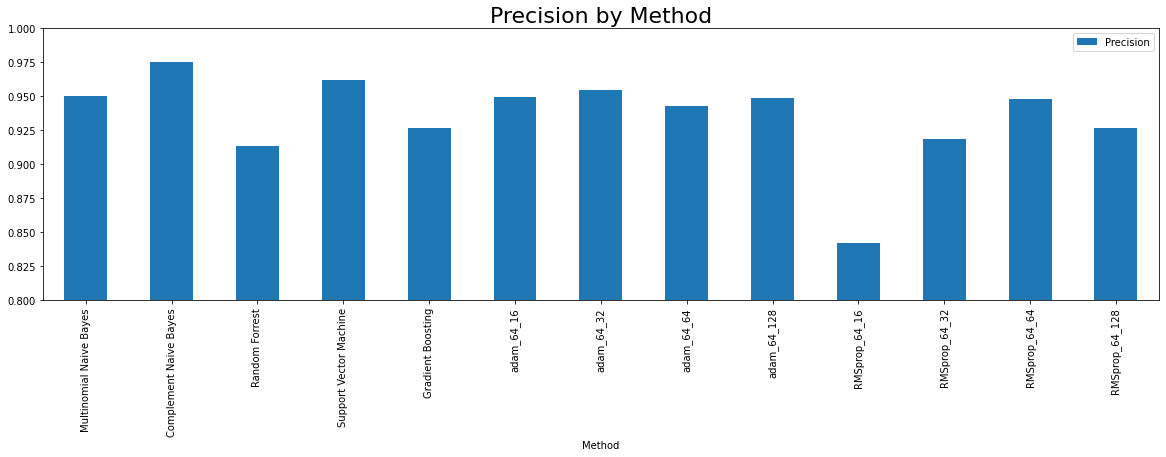

In [44]:
plt.rcParams["figure.figsize"] = (20,5)
fig = df.plot(x ='Method', y='Precision', kind = 'bar')
plt.title('Precision by Method', fontsize=22)

plt.ylim(0.8, 1.0)

plt.show()

## Recall Comparisons

The *recall_score* function of the **scikit** library measures the the ability of the classifier to find all the positive samples, when we look to our application we can think as our program identifying all spam.

In [45]:
df = pd.read_csv("./data/scores/general.csv")

sorted_precision = df.sort_values(by ='Recall', ascending=False)
display(sorted_precision[['Method', 'Recall']])

,Method,Recall
2,Random Forrest,0.999333
3,Support Vector Machine,0.996664
0,Multinomial Naive Bayes,0.996491
4,Gradient Boosting,0.989987
12,RMSprop_64_128,0.987409
10,RMSprop_64_32,0.986475
9,RMSprop_64_16,0.976826
5,adam_64_16,0.967973
6,adam_64_32,0.958439
7,adam_64_64,0.955600


Contrary to the initial belief, the best results were obtained with the *Random Forrest* and the *Support Vector Machine* after resampling, with the best result obtained with an *LSTM* being in fifth place, although the difference is smaller then one percent.

Bellow its possible to better see the precision in each model: 

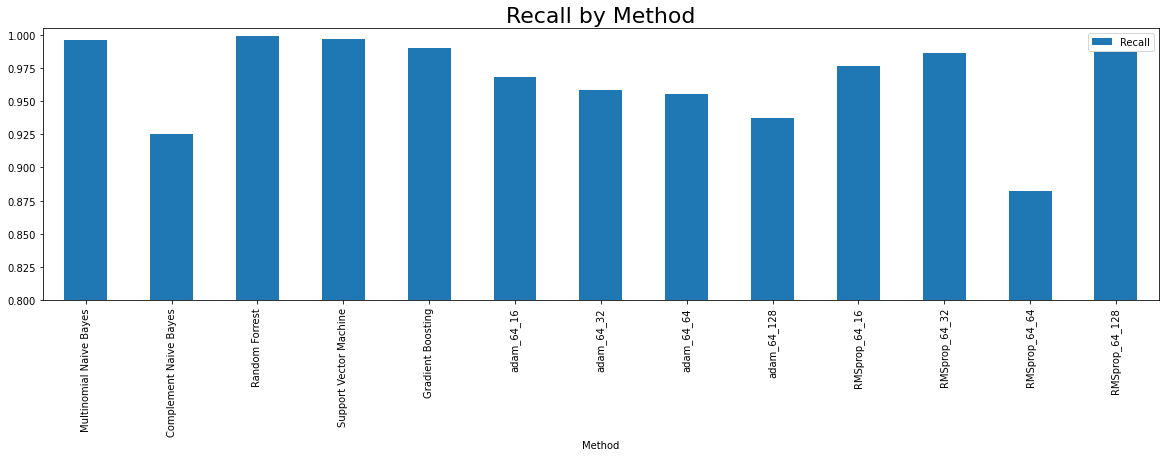

In [46]:
plt.rcParams["figure.figsize"] = (20,5)
fig = df.plot(x ='Method', y='Recall', kind = 'bar')
plt.title('Recall by Method', fontsize=22)

plt.ylim(0.8, 1.005)

plt.show()

## General Comparisons with Accuracy Score and F-measure


texto texto texto texto

In [47]:
from IPython.display import display_html
from itertools import chain,cycle

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    
    display_html(html_str,raw=True)
  

sorted_acc = df.sort_values(by ='Accuracy', ascending=False)
sorted_f = df.sort_values(by ='F-measure', ascending=False)

display_side_by_side(sorted_acc[['Method', 'Accuracy']],
                     sorted_f[['Method', 'F-measure']], 
                     titles=['Sorted by Accuracy','Sorted by F-Measure'])


,Method,Accuracy
3,Support Vector Machine,0.978654
5,adam_64_16,0.975631
6,adam_64_32,0.974859
12,RMSprop_64_128,0.973508
0,Multinomial Naive Bayes,0.973333
1,Complement Naive Bayes,0.971981
10,RMSprop_64_32,0.970220
7,adam_64_64,0.970028
8,adam_64_128,0.967121
4,Gradient Boosting,0.955636


Once again, contrary to the initial belief, the best results were obtained with the *Support Vector Machine* after resampling, with the best result obtained with an LSTM being in second and third places for accuracy and f-measure respectivly,  once more is interesting to note that the difference is smaller then one percent.

Bellow its possible to better see the precision in each model:

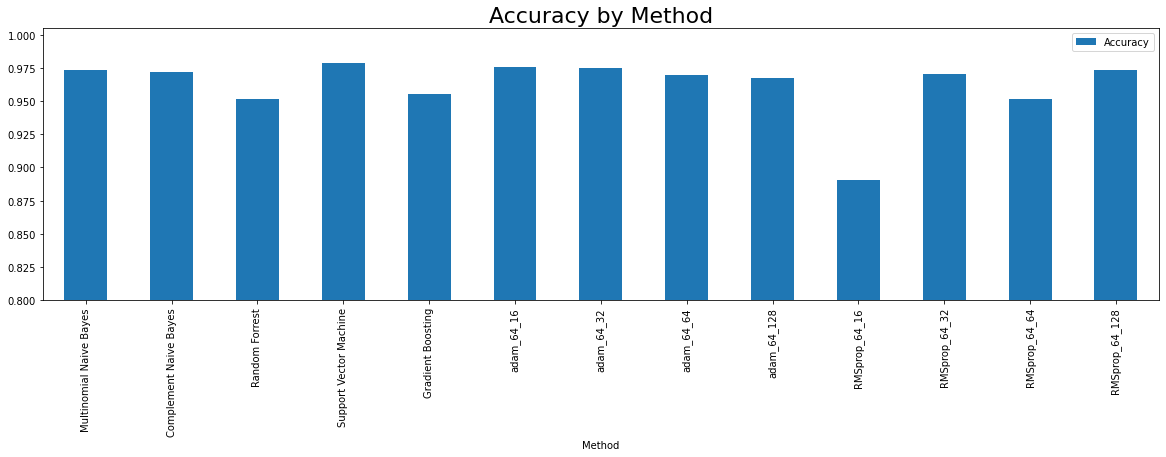

In [48]:
df.plot(x ='Method', color='tab:blue', y='Accuracy', kind = 'bar')
plt.title('Accuracy by Method', fontsize=22)

plt.ylim(0.8, 1.005)

plt.show()

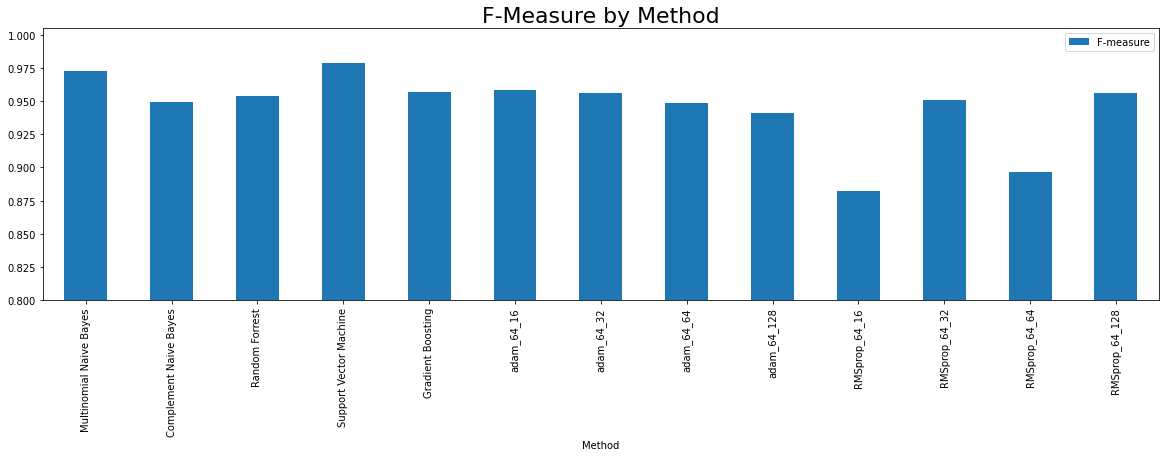

In [49]:
df.plot(x ='Method', color='tab:blue', y='F-measure', kind = 'bar')
plt.title('F-Measure by Method', fontsize=22)

plt.ylim(0.8, 1.005)
plt.show()

### Final Conclusions

After comparing all the methods using multiple metrics with cross-validation we can conclude that generally the *Support Vector Machine Classifier* is the most indicated algorithm for the given task. Although if the for the application prioritizes not marking legitimate e-mail as spam, *Complement Naive Bayes* might be more indicated, simmilarly, if the main worry is marking the most spam the *Random Forrest	Classificator* might be better.

# References:


- [Keras Documentation](https://keras.io/api/)
<br>

- [Sklearn Documentation](https://scikit-learn.org/stable/)
<br>

- [Understanding LSTM Networks, Stanford Tutorial](https://web.stanford.edu/class/cs379c/archive/2018/class_messages_listing/content/Artificial_Neural_Network_Technology_Tutorials/OlahLSTM-NEURAL-NETWORK-TUTORIAL-15.pdf)
<br>

- [Text	Classification and Naïve Bayes, Stanford Material](http://stanford.edu/~jurafsky/slp3/slides/7_NB.pdf)
<br>

- [Bayes’ Theorem, Stanford Encyclopedia of Philosophy Archive Spring 2019 Edition](https://plato.stanford.edu/archives/spr2019/entries/bayes-theorem/)
<br>

- **Harry Zhang**, The Optimality of Naive Bayes 
<br>

- **Bo Yu**, **Zong-ben Xu**, A comparative study for content-based dynamic spam classification using four machine learning algorithms, Knowledge-Based Systems, Volume 21, Issue 4, 2008, Pages 355-362,
<br>

- **Andrew Long**, [Understanding Data Science Classification Metrics in Scikit-Learn in Python](https://towardsdatascience.com/understanding-data-science-classification-metrics-in-scikit-learn-in-python-3bc336865019)